## Traditional ML classification models under wavelet analysis structures

In [1]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

### SVM
#### Read Data

In [2]:
# Configurations
LOWLUX = 'lowlux'
MIDLUX = 'middlelux'
HIGHLUX = 'highlux'
NOBACK = 'nothing'
ONEBACK = 'ONEBACK'
TWOBACK = 'TWOBACK'
THREEBACK = 'THREEBACK'
FILENAME = 'Filename'
IPA2 = 'IPA 2'
INDEX = 'index'
LUX = 'Lux'
LABELS = 'NBack Labels'
VALIDATIONSET = [1, 8, 14, 21, 24, 36, 41, 47]

In [3]:
# Read data and make them into processable formalities.
filepath = '../Data/Results/07-11-12-50/results.csv'
df_raw = pd.read_csv(filepath)
# df_raw

In [4]:
df_labels_IPA2 = df_raw[[FILENAME, IPA2]].copy()
df_labels_IPA2

,Filename,IPA 2
0,05-10-13-15-lowlux-nothing,0.120845
1,05-10-13-17-lowlux-ONEBACK,0.294440
2,05-10-13-19-lowlux-TWOBACK,0.135787
3,05-10-13-21-lowlux-THREEBACK,0.372591
4,05-10-13-28-highlux-nothing,0.196893
5,05-10-13-30-highlux-ONEBACK,0.229213
6,05-10-13-33-highlux-TWOBACK,0.314535
7,05-10-13-36-highlux-THREEBACK,0.254980
8,06-10-13-59-middlelux-nothing,0.321147
9,06-10-14-01-middlelux-ONEBACK,0.228015


In [5]:
# Labeling
luxes = []
nbacks = []
df_labels_IPA2 = df_labels_IPA2.reset_index()  # make sure indexes pair with number of rows
for index, row in df_labels_IPA2.iterrows():
    # Label luxes
    if LOWLUX in row[FILENAME]:
        luxes.append(30)
    elif MIDLUX in row[FILENAME]:
        luxes.append(4500)
    elif HIGHLUX in row[FILENAME]:
        luxes.append(12500)
    
    # Label task difficulties
    if NOBACK in row[FILENAME]:
        nbacks.append(0)
    elif ONEBACK in row[FILENAME]:
        nbacks.append(1)
    elif TWOBACK in row[FILENAME]:
        nbacks.append(2)
    elif THREEBACK in row[FILENAME]:
        nbacks.append(3)
df_labels_IPA2[LUX] = luxes
df_labels_IPA2[LABELS] = nbacks

In [6]:
df_labels_IPA2 = df_labels_IPA2.copy().drop([INDEX, FILENAME], axis=1)
df_labels_IPA2

,IPA 2,Lux,NBack Labels
0,0.120845,30,0
1,0.294440,30,1
2,0.135787,30,2
3,0.372591,30,3
4,0.196893,12500,0
5,0.229213,12500,1
6,0.314535,12500,2
7,0.254980,12500,3
8,0.321147,4500,0
9,0.228015,4500,1


#### Data visualization

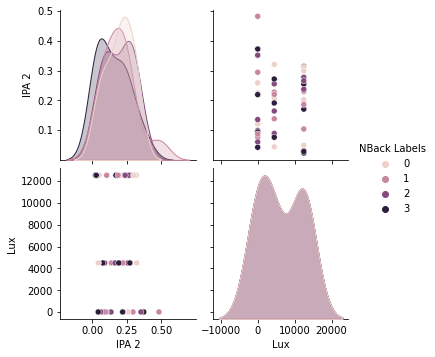

In [7]:
sns.pairplot(df_labels_IPA2, hue=LABELS)

#### Machine Learning

In [8]:
# Split the data into training dataset and validation dataset.

# Feature identification
FEATURE_SET = [IPA2, LUX] # The lux labels should be researved, or all the predicted results are labeled as 1 same label.
# FEATURE_SET = [IPA2]

# Training data
df_training = df_labels_IPA2.copy().drop(VALIDATIONSET, axis=0)
X_train = df_training[FEATURE_SET].to_numpy() # The features are IPAs and LUX.
y_train = df_training[[LABELS]].to_numpy()
y_train = np.reshape(y_train, -1)
                                      
# Validation data 
df_validation = df_labels_IPA2.copy().loc[VALIDATIONSET]
X_test = df_validation[FEATURE_SET].to_numpy()
y_test = df_validation[[LABELS]].to_numpy()
y_test = np.reshape(y_test, -1)

In [9]:
%%time
# Try SVM, bacause it is one of the most widely used models in cognitive workload claissfications.
clf = make_pipeline(StandardScaler(),SVC(kernel='poly', degree=7)) #SVC(kernel='rbf', gamma='auto'))
clf.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(degree=7, kernel='poly'))])

In [10]:
y_pred = clf.predict(X_test)
print(y_pred, y_test)

[0 3 0 2 2 3 2 0] [1 0 2 1 0 0 1 3]


In [11]:
# Accuracy score calculation.
accuracy_score(y_test, y_pred)

0.0

### KNN

In [12]:
%%time
# Train the model.
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

# Test.
y_pred = clf.predict(X_test)
print(y_pred, y_test)

# Accuracy score calculation.
accuracy_score(y_test, y_pred)

[0 3 0 2 2 3 2 0] [1 0 2 1 0 0 1 3]
CPU times: total: 0 ns
Wall time: 2.06 ms


0.0